Loading os and trying to use GPU 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0


In [2]:
#base path is the location of the repo on your computer
BASE_PATH = r"C:\Users\avark\Documents\snek"

In [3]:
#read the train_images_metadata.csv file
species = pd.read_csv(BASE_PATH + r"\src\Data\train_images_metadata.csv", index_col=0)

#read the venomous_status_metadata.csv file
venomous = pd.read_csv(BASE_PATH + r"\src\Data\venomous_status_metadata.csv", index_col=0)

#merging the 2 files, now every row from species contains a column with venomous status
combined = species.merge(venomous[["class_id", "MIVS"]], on="class_id", how="left")

#choosing the data you need for machine learning
relevant_info = combined[["binomial_name", "class_id", "MIVS", "image_path"]]

print(relevant_info.head())

         binomial_name  class_id  MIVS      image_path
0       Bitis caudalis       157     0      168482.JPG
1   Amphiesma stolatum        66     0    59067968.jpg
2        Lachesis muta       857     1    42704088.jpg
3         Vipera berus      1736     1  111487306.jpeg
4  Coronella austriaca       387     0  111486989.jpeg


Loading python images from folder

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

IMAGE_RESOLUTION=28


# Create a TensorFlow dataset for image loading
def load_img(path):
    img = tf.io.read_file(path)

    #3 channels because of rgb
    #img = tf.image.decode_jpeg(img, 3)
    #expand_animations = False needed, otherwise it
    img = tf.image.decode_image(img, channels=3, expand_animations = False)  
    img = tf.image.resize(img, [IMAGE_RESOLUTION, IMAGE_RESOLUTION])
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Find all of the image_paths 
image_path = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', img_path) for img_path in relevant_info['image_path'].values]

# Create the dataset and apply transformations
ds = tf.data.Dataset.from_tensor_slices(image_path)
ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)  # Load images in parallel
ds = ds.batch(32).prefetch(AUTOTUNE)  # Batch and prefetch for efficiency


In [5]:

# Labels are going to be either venomous, or non-venomous
labels = relevant_info['MIVS'].values 

#return processed image and corresponding label
def generator():
    for img_path, label in zip(image_path, labels):
        img = load_img(img_path)
        yield img, label  


# Create dataset
dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32) 
))

# Batch and prefetch for efficiency
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [6]:
from sklearn.model_selection import train_test_split

train_image_paths = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', path) for path in relevant_info["image_path"]]
train_labels = relevant_info["MIVS"].values

#1. split train: 80% train, 20% validation
train_image_paths, temp_image_paths, train_labels, temp_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# 2: split validation: 10% validation, 10% test
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    temp_image_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)


train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))


train_dataset = train_dataset.map(lambda x, y: (load_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (load_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)


train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras import Model

from re import X

input = Input(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3))
x = Rescaling(1./255)(input)

x = Conv2D(32, (3,3), padding='same', activation="relu")(input)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(64, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(128, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input, outputs=output, name='dvc_classification_model')
model.summary()

Model: "dvc_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 32)       │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,497 (525.38 KB)

 Trainable params: 134,497 (525.38 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
n_epochs = 10  # number of epochs to train the neural network
# checkpointing based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# model training
model_history = model.fit(
                            x= train_dataset,
                            epochs= n_epochs,
                            validation_data= val_dataset,
                            callbacks=[model_checkpoint_callback])

model.load_weights('model.keras')  # load weights back

Epoch 1/10
1659/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8000 - loss: 0.5044
Epoch 1: val_loss improved from None to 0.49553, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.8000 - loss: 0.5004 - val_accuracy: 0.8000 - val_loss: 0.4955
Epoch 2/10
1659/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8000 - loss: 0.4953
Epoch 2: val_loss improved from 0.49553 to 0.49298, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.8000 - loss: 0.4945 - val_accuracy: 0.8000 - val_loss: 0.4930
Epoch 3/10
1659/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8000 - loss: 0.4931
Epoch 3: val_loss improved from 0.49298 to 0.49092, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8000 - loss: 0.4919 - val_accuracy: 0.8000 - val_loss: 0.4909
Epoch 4/10
1659/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8000 - loss: 0.4909
Epoch 4: val_loss improved from 0.49092 to 0

In [10]:
# Create TensorFlow datasets for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

# Apply preprocessing and map to TensorFlow dataset
test_dataset = test_dataset.map(lambda x, y: (load_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the datasets for efficiency
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [11]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8003 - loss: 0.4907
Test Loss:  0.4906900227069855
Test Accuracy:  0.8003309965133667


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


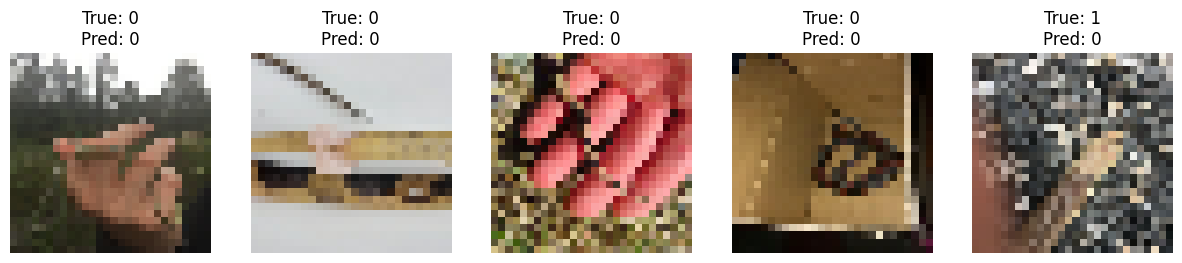

C:\Users\avark\Documents\snek\src\Data\train_images_small\194811384.jpeg
C:\Users\avark\Documents\snek\src\Data\train_images_small\194811384.jpeg
C:\Users\avark\Documents\snek\src\Data\train_images_small\194811384.jpeg
C:\Users\avark\Documents\snek\src\Data\train_images_small\194811384.jpeg
C:\Users\avark\Documents\snek\src\Data\train_images_small\194811384.jpeg


In [12]:
#show a few results

def plot_example_results(model, image_paths, true_labels, num_examples=5):
    example_paths = []
    # Randomly select a few images
    indices = np.random.choice(len(image_paths), size=num_examples, replace=False)
    
    plt.figure(figsize=(15, 5))
    
    for i, index in enumerate(indices):
        image_path = image_paths[index]
        true_label = true_labels[index]
        
        example_paths.append(image_path)
    
        image = load_img(image_path)
        
        # Add the batch dimension
        image = tf.expand_dims(image, axis=0)
        
        # Make a prediction on the image
        prediction = model.predict(image)
        predicted_label = (prediction > 0.5).astype(int)
        
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label[0][0]}")
    
    plt.show()
    
    #returns the paths of the examples
    return example_paths

ex = plot_example_results(model, test_image_paths, test_labels, num_examples=5)

#printing the image_path attributes
for i in range(len(ex)):
    print(ex[1])
